In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, SGDClassifier
from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics.pairwise import cosine_similarity
import pubchempy as pcp
os.chdir('../')
from util.util import *
from modules.logit_predictor import PlastPredictor
os.chdir('notebooks')


import IPython.display as Disp
np.set_printoptions(suppress=True)

Making sure the new `logit_predictor` predictor model is working properly

In [18]:
# Load and format data
pl_full = pd.read_pickle('../database/plasticizer_data_v10_polarity.pkl')
org_full = pd.read_pickle('../database/org_polarity_v2.pkl')
pl_pol = pd.concat([pl_full[pl_full.columns[1:195]], pl_full['Polarity']], axis=1)
all_cols = pl_pol.columns.to_numpy()
pl_data = pl_pol[all_cols].to_numpy()
org_data = org_full[all_cols].to_numpy()
lin_data = pd.read_pickle('../database/linolein_test.pkl')
lin_data['Polarity'] = 0.048856
lin_data = lin_data[all_cols].to_numpy()

In [10]:
pp = PlastPredictor()
pp.fit_model(pl_data, org_data)

In [11]:
pp.pl_train_acc, pp.pl_test_acc, pp.org_train_acc, pp.org_test_acc

(1.0, 0.9285714285714286, 0.9776424377083003, 0.9777813045548326)

In [12]:
org_acc = pp.predict(org_data, type='binary', class_id='neg')
pl_acc = pp.predict(pl_data, type='binary', class_id='pos')
lin_prob = pp.predict(lin_data)
org_acc, pl_acc, lin_prob

(0.9784002539279479, 0.9333333333333333, array([0.96342849]))

Looks like it works. Now just need to generate likelihood data for all plasticizers and PubChem organics

**NOTE:** This is without filtering organics by least similar. The final model should do this to ensure the negative samples are definitely not plasticizers

In [20]:
pl_probs = pp.predict(pl_data)
pl_smiles = pl_full['SMILES'].to_numpy()
org_probs = pp.predict(org_data)
org_smiles = org_full['SMILES'].to_numpy()

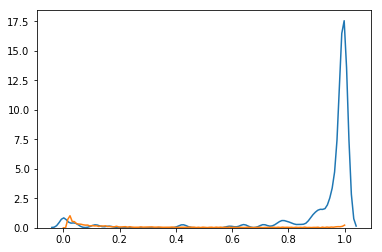

In [15]:
sns.distplot(pl_probs, hist=False)
sns.distplot(org_probs, hist=False)
plt.show()

In [22]:
best_org_probs, best_org_smiles = zip(*reversed(sorted(zip(org_probs, org_smiles))))
worst_pl_probs, worst_pl_smiles = zip(*sorted(zip(pl_probs, pl_smiles)))

In [33]:
org_ll = {'SMILES': org_smiles, 'Likelihood': org_probs}
org_ll = pd.DataFrame(org_ll)
org_ll.to_pickle('../database/org_likelihoods_v1.pkl')

In [36]:
pl_ll = {'SMILES': pl_smiles, 'Likelihood': pl_probs}
pl_ll = pd.DataFrame(pl_ll)
pl_ll.to_pickle('../database/pl_likelihoods_v1.pkl')